In [1]:
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch

model_id = "google/ddpm-celebahq-256"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model and scheduler
unet = UNet2DModel.from_pretrained(model_id) 

unet.eval()
unet.to(device)

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

## Load The Image

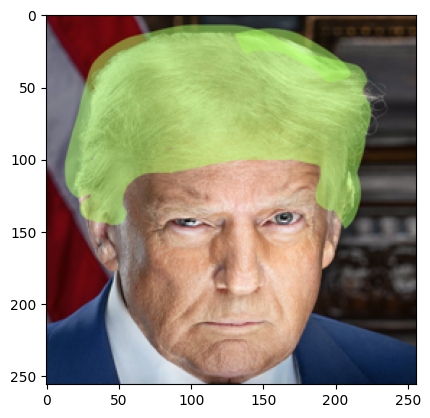

In [17]:
from PIL import Image
import numpy as np
from torchvision import transforms

transform = transforms.Compose([ transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5]),
])

ref_image = Image.open('dt_hair.png').resize((256,256)).convert('RGB')
ref_image = transform(ref_image).unsqueeze(0).to(device)

plt.imshow(ref_image.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
plt.show()


## Image Compositing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0621228..2.6405876].


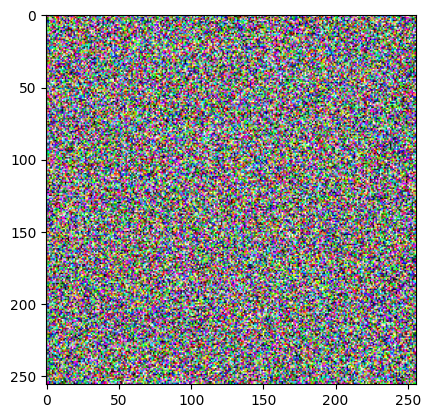

In [15]:
scheduler = DDIMScheduler(beta_start=0.0001, beta_end=0.02, beta_schedule="linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

denoising_t = 800

torch.manual_seed(0)
t=torch.tensor([denoising_t]).long().to(device)

noise = torch.randn_like(ref_image).to(device)
x_noised = scheduler.add_noise(ref_image, noise, t)
x_noised = x_noised.to(device)

plt.imshow(x_noised.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

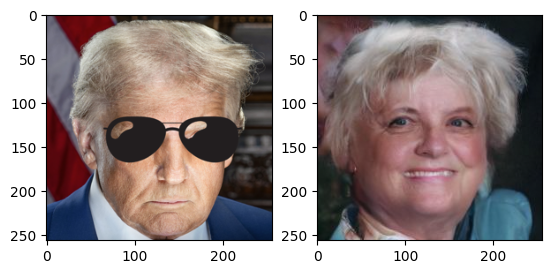

In [9]:
from IPython.display import clear_output

x_t = x_noised

# Denoising Loop
for t in tqdm(scheduler.timesteps,total=scheduler.num_inference_steps,leave=False):
    
    if t > denoising_t:
        continue
    
    with torch.no_grad():
        noise_pred = unet(x_t,t.to(device)).sample
        
    x_t = scheduler.step(noise_pred, t.to(device), x_t).prev_sample
    

plt.subplot(1,2,1)
plt.imshow(ref_image.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
plt.subplot(1,2,2)
plt.imshow(x_t.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
# clear_output(wait=True)
plt.show()

# Making various Combination of denoising strength

  0%|          | 0/50 [00:00<?, ?it/s]

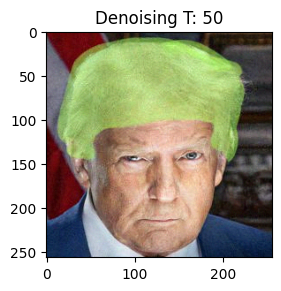

  0%|          | 0/50 [00:00<?, ?it/s]

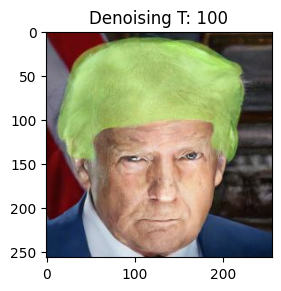

  0%|          | 0/50 [00:00<?, ?it/s]

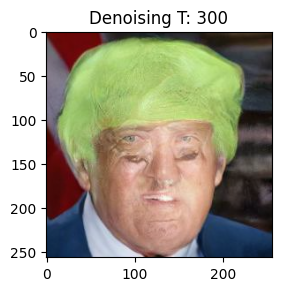

  0%|          | 0/50 [00:00<?, ?it/s]

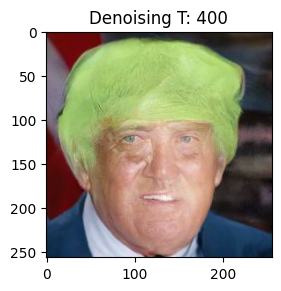

  0%|          | 0/50 [00:00<?, ?it/s]

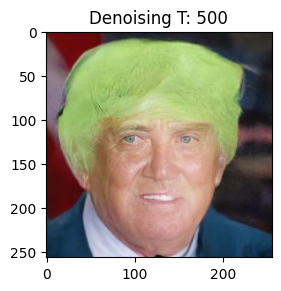

  0%|          | 0/50 [00:00<?, ?it/s]

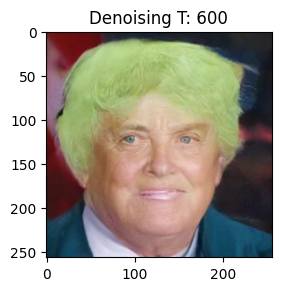

  0%|          | 0/50 [00:00<?, ?it/s]

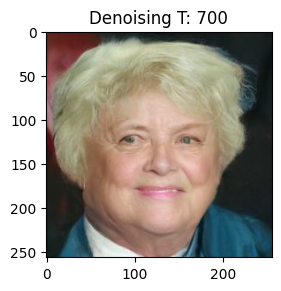

  0%|          | 0/50 [00:00<?, ?it/s]

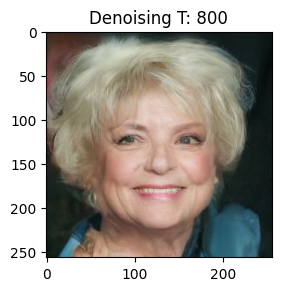

  0%|          | 0/50 [00:00<?, ?it/s]

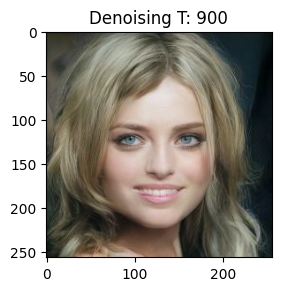

  0%|          | 0/50 [00:00<?, ?it/s]

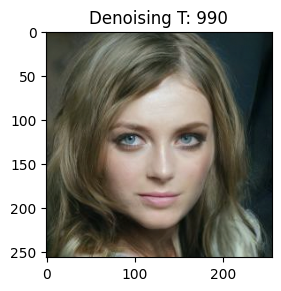

In [19]:
scheduler = DDIMScheduler(beta_start=0.0001, beta_end=0.02, beta_schedule="linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

for denoising_t in [50,100,300,400,500,600,700,800,900,990]:

    torch.manual_seed(0)
    t=torch.tensor([denoising_t]).long().to(device)

    noise = torch.randn_like(ref_image).to(device)
    x_noised = scheduler.add_noise(ref_image, noise, t)
    x_noised = x_noised.to(device)

    x_t = x_noised
    # Denoising Loop
    for t in tqdm(scheduler.timesteps,total=scheduler.num_inference_steps,leave=False):
        
        if t > denoising_t:
            continue
        
        with torch.no_grad():
            noise_pred = unet(x_t,t.to(device)).sample
            
        x_t = scheduler.step(noise_pred, t.to(device), x_t).prev_sample
        

    plt.subplot(1,2,1)
    plt.imshow(x_t.squeeze().permute(1,2,0).cpu().numpy()*0.5+0.5)
    plt.title(f'Denoising T: {denoising_t}')
    # clear_output(wait=True)
    plt.show()